**Problem 2: Variational Autoencoders on Poor Sevens**

Importing all the libraries

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math
import warnings
warnings.filterwarnings("ignore")

Mounting the google drive files to load the input data

In [280]:
from google.colab import drive
drive.mount('/content/gdrive')
directory='/content/gdrive/My Drive/Masters/DeepLearning/Homework4/Data/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Function to read the pickle object

In [0]:
def read_pkl(name):
  with open(name+'.pkl', 'rb') as f:
      X = pickle.load(f)
  return X

Get the training & test dataset

In [0]:
train=read_pkl(directory+'hw4_tr7')
test=read_pkl(directory+'hw4_te7')
train=np.vstack((train,test))

In [0]:
tf.reset_default_graph()  # To reset all the parameters of the graph for every execution
batch_size=100

Parameters of the Convolutional Layer

In [0]:
filter1=32  # Number of filters in 1st Convolutional Layer
kernel_size=(2,2)  # Filter size
kernel_stride=2  # Kernel stride
pad='valid'  # Padding type
filter2=64  # Number of filters in 2nd Convolutional Layer
k=4  # Dimension of the Latent variables

Encoder function of VAE

In [0]:
def encoder(x,keep_prob):
  # 1st Convolutional Layer
  conv1=tf.layers.conv2d(tf.expand_dims(x,-1),filters=filter1,strides=kernel_stride,kernel_size=kernel_size,padding=pad,activation=tf.nn.relu,
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),name='conv1')
  conv1 = tf.nn.dropout(conv1, keep_prob=keep_prob)  # Dropout

  # 2nd Convolutional Layer
  conv2=tf.layers.conv2d(conv1,filters=filter2,strides=kernel_stride,kernel_size=kernel_size,padding=pad,activation=tf.nn.relu,
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),name='conv2')
  conv2 = tf.nn.dropout(conv2, keep_prob=keep_prob)

  # Fully Connected Layer to learn the parameters of the probability distribution of the Latent variables
  mean=tf.layers.dense(tf.layers.flatten(conv2),k,activation=tf.nn.tanh,kernel_initializer=tf.contrib.layers.xavier_initializer(),name='mean')
  sd=tf.layers.dense(tf.layers.flatten(conv2),k,activation=tf.nn.sigmoid,kernel_initializer=tf.contrib.layers.xavier_initializer(),name='sd')
  return mean,sd

Reparameterisation function of VAE

In [0]:
def reparameterize(mean, sd):
    return tf.random.normal(shape=[1,k]) * sd + mean  # z=sigma*epsilon+mean

Decoder function of VAE

In [0]:
def decoder(z,keep_prob):
  # 1st Fully connected layer
  t_dense1=tf.layers.dense(z,1568,activation=tf.nn.relu,kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),name='t_dense1')
  t_dense1=tf.reshape(t_dense1,[-1,7,7,filter1])
  
  # 1st Deconvolution layer
  conv1_t=tf.layers.conv2d_transpose(t_dense1,filters=filter2,kernel_size=kernel_size,strides=kernel_stride,padding='same',
                                     kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),activation=tf.nn.relu)
  conv1_t=tf.nn.dropout(conv1_t,keep_prob=keep_prob)  # Dropout
  
  # 2nd Deconvolution layer
  conv2_t=tf.layers.conv2d_transpose(conv1_t,filters=filter1,kernel_size=kernel_size,strides=kernel_stride,padding='same',
                                     kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),activation=tf.nn.relu)
  conv2_t=tf.nn.dropout(conv2_t,keep_prob=keep_prob)
  
  # 2nd Fully connected layer to generate new images 
  t_dense2=tf.layers.dense(tf.layers.flatten(conv2_t),784,activation=tf.nn.relu,kernel_initializer=tf.contrib.layers.variance_scaling_initializer())
  return tf.reshape(t_dense2,[-1,train.shape[1],train.shape[2]])

Function to generate code vectors from the learned parameters of probability distribution of latent space

In [0]:
def generate_code_vectors(mu,sigma,dim):
  size=21
  codes=np.zeros((size,k))
  for i in range(k):
    if i==dim:
      codes[:,i]=np.arange(-5,5.5,0.5)  # Alter the 'dim' dimension of the code vectors
    else:
      codes[:,i]=np.repeat(np.random.normal(mu[i],sigma[i],1),size)  # keep the other dimensions of the code vectors constant
  return codes

Defining the flow of the VAE network

In [0]:
x=tf.placeholder(tf.float32,shape=[None,train.shape[1],train.shape[2]])  # Input placeholder
keep_prob=tf.placeholder(tf.float32)  # keep_prob=1-dropout
codes=tf.placeholder(tf.float32,shape=[None,k])  # placeholder for the code vectors
mean,sd=encoder(x,keep_prob)
codes=reparameterize(mean,sd)
reconst=decoder(codes,keep_prob)

Training the VAE network

In [290]:
loss=tf.losses.mean_squared_error(x,reconst)  # Mean squared error function
train_step=tf.train.AdamOptimizer(learning_rate=0.00001).minimize(loss)  # Adam optimizer with learning rate of 0.00001
sess=tf.InteractiveSession()
tf.global_variables_initializer().run()  # Initialize all the graph variables
maxEpoch=1001
for im in range(maxEpoch):
  i=0
  indices=np.arange(train.shape[0])
  np.random.shuffle(indices)  # Shuffle the order of the training data
  offset=batch_size
  while i<len(indices):
    errt,_=sess.run([loss,train_step],feed_dict={x:train[indices[i:i+offset]],keep_prob:0.7})  # Minibatch training
    i+=offset
    if (i+offset)>train.shape[0]:
      offset=train.shape[0]-i
    break
  if not im%100:
    print('Epoch number:{} Loss:{}'.format(im,errt))

Epoch number:0 Loss:0.16763944923877716
Epoch number:100 Loss:0.06916237622499466
Epoch number:200 Loss:0.06929740309715271
Epoch number:300 Loss:0.08377832174301147
Epoch number:400 Loss:0.06580597907304764
Epoch number:500 Loss:0.06515074521303177
Epoch number:600 Loss:0.058817747980356216
Epoch number:700 Loss:0.06022217869758606
Epoch number:800 Loss:0.05696269869804382
Epoch number:900 Loss:0.0552380196750164
Epoch number:1000 Loss:0.05449248477816582


Generate new samples with the randomly generated code vectors

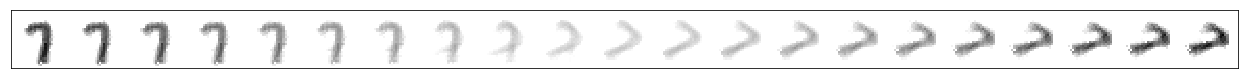

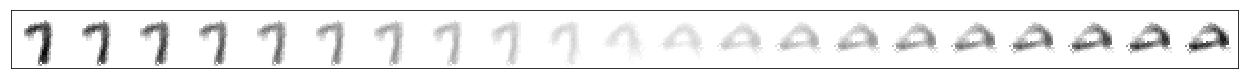

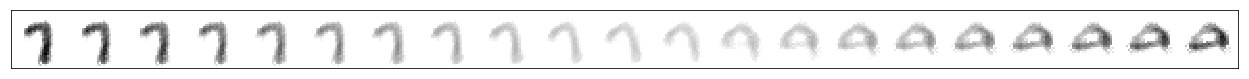

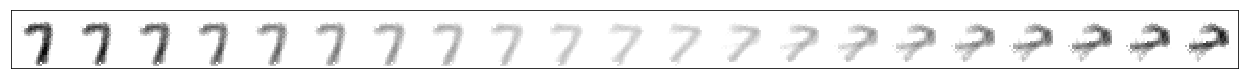

In [291]:
z,mu,sigma,c=sess.run([reconst,mean,sd,codes],feed_dict={x:train,keep_prob:1})
for i in range(k):
  index=np.random.randint(train.shape[0],size=1)
  code_vectors=generate_code_vectors(mu[index[0]],sigma[index[0]],0)
  generated_samples=sess.run(reconst,feed_dict={codes:code_vectors,keep_prob:1})
  new_samples=generated_samples[0]
  for j in range(1,generated_samples.shape[0]):
    new_samples=np.hstack((new_samples,generated_samples[j]))
  plot_fig(new_samples)  # plot the new images generated from the code vectors

Function to plot the image

In [0]:
def plot_fig(q):
  fig = plt.figure(figsize=(23, 7))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(q,cmap = plt.cm.binary)
  plt.xticks(np.array([]))
  plt.yticks(np.array([]))
  plt.show()

In [0]:
sess.close()